In [3]:
import os
import numpy as np
from scipy import ndimage
import pandas as pd
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns
import nibabel as nib
from nilearn import plotting

In [11]:
dataI = pd.read_csv('dataI_with_stage.csv') ; dataI = dataI.drop('Unnamed: 0', axis = 1)
dataP = pd.read_csv('dataP_with_stage.csv') ; dataP = dataP.drop('Unnamed: 0', axis = 1)
dataTrack = pd.read_csv('dataTrack_with_stage.csv') ; dataTrack = dataTrack.drop('Unnamed: 0', axis = 1)
dataP['subjid'] = dataP['subjid'].astype(str)  # so that we can work with sklearn group split
dataSet  = pd.concat([dataI, dataP, dataTrack])
print(dataSet.shape)
patients = dataSet.loc[dataSet['group'] != 'control']
patients.reset_index(drop=True , inplace = True)
print(patients.shape)

(4407, 308)
(2932, 308)


In [12]:
def normalize_point_cloud(points):
	centroid = np.mean(points, axis=0)
	points -= centroid
	furthest_distance = np.max(np.sqrt(np.sum(abs(points)**2,axis=-1)))
	points /= furthest_distance

	return points

def find_surface_indices(array):
    labeled_array, num_features = ndimage.label(array)
    surface_indices = []

    for label in range(1, num_features + 1):
        component = (labeled_array == label)
        borders = ndimage.find_objects(component)

        for border in borders:
            x_slices, y_slices, z_slices = border
            x_vals, y_vals, z_vals = np.where(component[x_slices, y_slices, z_slices])
            x_coords = x_slices.start + x_vals
            y_coords = y_slices.start + y_vals
            z_coords = z_slices.start + z_vals

            coordinates = np.column_stack((x_coords, y_coords, z_coords))
            surface_indices.extend(coordinates)
            
    # Normalize the surface points
    surface_indices = normalize_point_cloud(surface_indices)
    num_surface_points = len(surface_indices)

    surface_indices = np.transpose(np.array(surface_indices))

    return  surface_indices, num_surface_points

In [13]:
REGION_LABEL = 4 # Name:Left-Lateral-Ventricle

In [14]:
subject_row = patients.iloc[2021]
path = subject_row['identifier'] + '/mri/'
print(subject_row['group'])

roi = nib.load(path + 'aseg.mgz')
roi_data = roi.get_fdata()
roi_data[roi_data != REGION_LABEL] = 0

P, n  = find_surface_indices(roi_data)
print(P.shape)

symp-HD
(3, 8982)


In [ ]:
roi_data.shape

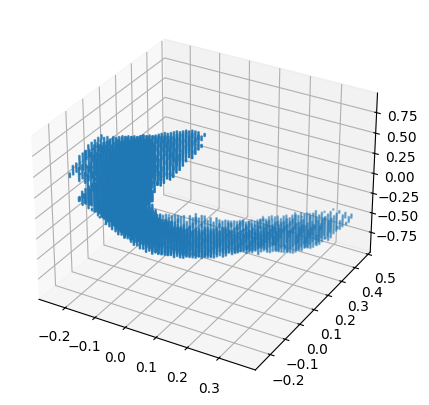

In [15]:
# Create a 3D scatter plot with custom colors
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(P[0], P[1], P[2] , s= 1)

In [16]:
P.shape

(3, 8982)

In [17]:
REGION_LABELS = [4, 10, 11, 12, 13, 17 , 18, 26]

# Create the header for the CSV file
header = ['index' , 'identifier']
for label in REGION_LABELS:
    header.append(f'n_{label}')

# Open the CSV file in append mode and write the header
with open('point_Clouds_info.csv', 'a', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(header)
    
    # Iterate over each row in the data DataFrame
    for index, subject_row in tqdm(patients.iterrows()):
        subject_path = subject_row['identifier'] 
        
        # Create a list to store data for the current subject
        subject_data = [index , subject_path]
        
        # Iterate over each region label
        for region_label in REGION_LABELS:
            roi = nib.load(subject_path + '/mri/' + 'aseg.mgz')
            roi_data = roi.get_fdata()
            roi_data[roi_data != region_label] = 0

            P, n  = find_surface_indices(roi_data)
            subject_data.append(n)

            # Create folder path
            folder_name = f'Point_clouds/{index}'
            
            # Create the directory if it does not exist
            os.makedirs(folder_name, exist_ok=True)
            
            # Define the CSV file path
            csv_file_path = os.path.join(folder_name, f'region{region_label}.csv')
            
            # Save the np.array P as a CSV file
            P_df = pd.DataFrame(P)
            P_df.to_csv(csv_file_path,index = False)
                        
        # Write the data for the current subject to the CSV file
        csv_writer.writerow(subject_data)  
        
        # Flush the buffer to ensure immediate update
        csvfile.flush()

2932it [12:51:05, 15.78s/it]
